In [1]:
import cPickle as pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
location = '/gpfs01/bethge/home/oeberle/Scripts/deepgaze/'

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook.py:128: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the matplotlib toolkit finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [5]:
cd ..

/gpfs01/bethge/home/oeberle/Scripts/deepgaze


In [2]:
def get_image_from_filename(scene_category, filename, root_dir):
    '''
    Use np.asarray(jpgfile) to get rgb data 
    '''
    import Image


    img_dir =  root_dir + '/Targets/' + scene_category + '/' + filename
    try:
        jpgfile = Image.open(img_dir)
        typ = 'target'
    except IOError:
        img_dir =  root_dir + '/Fillers/' + scene_category + '/' + filename
        try:
            jpgfile = Image.open(img_dir)
            typ = 'filler'
        except IOError:
            typ ='missing'
            jpgfile = None
            
    return typ, jpgfile, np.asarray(jpgfile)


In [ ]:
root_dir = location + 'FIGRIM/Stimuli/'
for f in sorted(glob.glob(res_dir + "*.p")):
    res = pickle.load(open(f, 'r'))

    if res['type'] == 'target':
        print( res['type'], res['HR'], res['scene category'], res['filename'], res['TS'])
        plt.imshow(get_image_from_filename(res['scene category'], res['filename'], root_dir)[2])
        plt.show()
    else:
        pass

In [2]:
cd ..

/gpfs01/bethge/home/oeberle/Scripts/deepgaze


In [6]:

from __future__ import print_function, division, unicode_literals
#import TotalSaliency as TS
import numpy as np
import itertools
import scipy
import matplotlib.pyplot as plt
import zipfile
%matplotlib inline
from boltons.fileutils import mkdir_p
from tqdm import tqdm
import shutil
import warnings
import glob
import itertools
import pysaliency
from pysaliency import get_FIGRIM
from baseline_models import BaselineModel, ShapeIndependentBaselineModel
import cPickle as pickle
import theano

/usr/local/lib/python2.7/dist-packages/optpy/ipopt_wrapper.py:15: UserWarning: Could not import ipopt. Probably cyipopt is not installed
  warnings.warn('Could not import ipopt. Probably cyipopt is not installed')


In [7]:
import yaml
import os
import dill

from train_deep_gaze import get_dataset, load_experiment, load_parameters
from scipy.ndimage import zoom
from boltons.cacheutils import LRU

class DeepGazeModel(pysaliency.Model):
    """
    Create and provide a set of DeepSal objects for different image sizes.
    """
    def __init__(self, directory, crossval_id = 0, centerbias_model=None, network_cache=None, **kwargs):
        super(DeepGazeModel, self).__init__(**kwargs)
        self.directory = directory
        self.crossval_id = crossval_id
        if network_cache is None:
            self.networks = LRU(max_size=2)
        else:
            print("Reusing network cache")
            self.networks = network_cache
        self.centerbias_model = centerbias_model
        self.params = load_parameters(self.directory, crossval_id = self.crossval_id)

    def load_network(self, size):
        new_network = load_experiment(self.directory, size, crossval_id = self.crossval_id)
        new_network.prepared_output_cache.size = 4
        self.networks[size] = new_network

        return self.networks[size]

    def prepare_centerbias(self, stimulus):
        
        size = (stimulus.shape[0], stimulus.shape[1])
        network = self.get_network(size)
        
        centerbias = self.centerbias_model.log_density(stimulus)

        y_size = network.salmap_shape[0]
        x_size = network.salmap_shape[1]

        image_area = (x_size*y_size)/(size[0]*size[1])

        factor_x = x_size/centerbias.shape[1]
        factor_y = y_size/centerbias.shape[0]
        #print('shapes', size, centerbias.shape)
        #print('factors', factor_x, factor_y)

        centerbias = zoom(centerbias, [factor_y, factor_x], order=1, mode='nearest')
        centerbias_density = np.exp(centerbias)
        centerbias -= (np.log(centerbias_density.sum()) - np.log(image_area))
        #print "This centre bias:", np.exp(centerbias).sum()
        np.testing.assert_allclose(np.exp(centerbias).sum(), image_area)

        return centerbias

    def get_network(self, shape):
        if shape not in self.networks:
            self.load_network(shape)
        network = self.networks[shape]
        for p, v in zip(network.params, self.params):
            p.set_value(v)

        return network

    def _log_density(self, stimulus):
        """Generate saliencymap for given image using given centerbias
        centerbias_template == None falls back to default centerbias template
        """
        shape = (stimulus.shape[0], stimulus.shape[1])
        network = self.get_network(shape)
        centerbias = self.prepare_centerbias(stimulus)
        #print(centerbias.shape)
        
        network_input = network.prepare_network_input(self.ensure_color(stimulus).copy())
        
        saliency_map = network.generate_log_densities(network_input.astype(theano.config.floatX),
                                                      centerbias.astype(theano.config.floatX))
        if saliency_map.shape != shape:
            print("WARNING! WRONG SHAPE!!! {} != {}. Resizing".format(saliency_map.shape, shape))
            saliency_map = zoom(saliency_map, [shape[0]/saliency_map.shape[0], shape[1]/saliency_map.shape[1]])
            
            saliency_map -= np.log(np.sum(np.exp(saliency_map)))
            
            assert saliency_map.shape == shape
        return saliency_map

    def ensure_color(self, image):
        if image.ndim == 2:
            return np.dstack((image, image, image))
        return image

    
def load_val_deepgaze_model(directory, centerbias_model=None, network_cache=None, **kwargs):
    config = yaml.load(open(os.path.join(directory, 'config.yaml')))
    baseline_path = config['centerbias'].get('disk_cache', '.')
    crossval_id = 0
    #val_baseline_name = os.path.join(directory, baseline_path, 'baseline_val_{}.pydat'.format(crossval_id))
    #val_baseline = dill.load(open(val_baseline_name))
    #val_baseline = dill.load(open('deepgaze2_2/experiments/cache/MIT1003_twosize-10-0-rand/'))
    
    return DeepGazeModel(directory, centerbias_model=centerbias_model, network_cache=network_cache, **kwargs)


def glue_images(imga, imgb, offset = 500):
    """
    Combines two color image ndarrays side-by-side.
    """
    ha,wa = imga.shape[:2]
    hb,wb = imgb.shape[:2]
    max_height = np.max([ha, hb])
    #if max_height % 2. != 0:
    #    max_height = max_height + 1
    offset = np.max([wa,wb])
    total_width = wa+wb+offset
   
    #new_img[:ha,:wa]=imga
    #new_img[:hb,wa+offset:wa+wb+offset]=imgb
    hdiff = int(np.ceil((ha-hb)/2.))
    
    #Adding borders
    max_height = max_height + 2*np.abs(hdiff)
    total_width = total_width + 2*np.abs(hdiff)
    new_img = np.zeros(shape=(max_height, total_width, 3), dtype=np.uint8)

    #print(hdiff)
    if hdiff >= 0: # imgb smaller than imga
        new_img[hdiff:ha+hdiff,hdiff:wa+hdiff]=imga
        new_img[2*hdiff:hb+2*hdiff,wa+offset+hdiff:wa+wb+offset+hdiff]=imgb
    elif hdiff < 0: # imga smaller than imgb
        hdiff = np.abs(hdiff)
        new_img[2*hdiff:ha+2*hdiff,hdiff:wa+hdiff]=imga
        new_img[hdiff:hb+hdiff,wa+offset+hdiff:wa+wb+offset+hdiff]=imgb
        
    center = wa + hdiff + int(np.ceil(offset/2.))
    return new_img, center


class TotalSaliency(object):
    def __init__(self, img1, img2):
        self.img1 = img1
        self.img2 = img2
    def __call__(self):    
        im_glued, center = glue_images(self.img1, self.img2)
        log_density = uniform_dg_model.log_density(stimulus=im_glued)
        #print(log_density.shape)
        d_left, d_right = self.get_total_saliency(log_density, center)
        return im_glued,log_density, d_left, d_right
    
    def get_total_saliency(self, log_density,center):
        density = np.exp(log_density)
        d_left = np.sum(density[:,:center])
        d_right = np.sum(density[:, center:])
        return d_left, d_right

In [13]:
figrim_stimuli, figrim_fixations= get_FIGRIM(location=location)

base_directory = 'TrainedModels/experiment0010_SALICONMIT2_MIT2_rand'
#target_directory = 'model_caches/deep_gaze_2/experiment0010_SALICONMIT2_MIT2_rand/'
config = yaml.load(open(os.path.join(base_directory, 'crossval_10-0', 'config.yaml')))


baseline = ShapeIndependentBaselineModel([figrim_stimuli], [figrim_fixations], config['centerbias']['bandwith'], regularization=config['centerbias']['regularization'])

cb_dg_models = []
uniform_dg_models = []
for crossval in sorted(glob.glob(os.path.join(base_directory, 'crossval*'))):
    if uniform_dg_models:
        network_cache = uniform_dg_models[0].networks
    else:
        network_cache = None
    
    uniform_dg_model = load_val_deepgaze_model(crossval, centerbias_model=pysaliency.UniformModel(),
                                               network_cache=network_cache)
    uniform_dg_models.append(uniform_dg_model)
    
    cb_dg_model = load_val_deepgaze_model(crossval, centerbias_model=baseline,
                                          network_cache=uniform_dg_models[-1].networks)
    cb_dg_models.append(cb_dg_model)
    
    
    #config = yaml.load(open(os.path.join(crossval, 'config.yaml')))
    #dataset, f = get_dataset(config['optimization']['val_dataset'], location='test_datasets')
    #for s in dataset:
    #    dg_model.log_density(s)
    #    clear_output()
uniform_dg_model = pysaliency.MixtureModel(uniform_dg_models)
cb_dg_model = pysaliency.MixtureModel(cb_dg_models)

#data = get_memory_scores('http://figrim.mit.edu/within_category.csv',location + 'FIGRIM/Memory/', 'within_category')
#data2 = get_memory_scores('http://figrim.mit.edu/across_category.csv',location + 'FIGRIM/Memory/', 'across_category')

2793 (100.0%)
Reusing network cache
Reusing network cache
Reusing network cache
Reusing network cache
Reusing network cache
Reusing network cache
Reusing network cache
Reusing network cache
Reusing network cache
Reusing network cache
Reusing network cache
Reusing network cache
Reusing network cache
Reusing network cache
Reusing network cache
Reusing network cache
Reusing network cache
Reusing network cache
Reusing network cache


# Within Categories

In [ ]:

import glob
res_dir = '/gpfs01/bethge/home/oeberle/Scripts/deepgaze/OliverPlayground/Memory_within_Scenes/'
HR = []
FAR = []
ACC = []
TS = []
for f in sorted(glob.glob(res_dir + "*.p")):
    res = pickle.load(open(f, 'r'))
        
    if res['type'] == 'target':
        print( res['type'])
        HR.append(res['HR'])
        FAR.append(res['FAR'])
        ACC.append(res['ACC'])
        TS.append(res['TS'])
        
    else:
        pass
data_within = {'HR':HR, 'FAR': FAR, 'ACC': ACC, 'TS':TS}
pickle.dump(data_within,open(location + 'FIGRIM/Memory/'+ 'data_within_{}.p'.format(len(glob.glob(res_dir + "*.p"))), 'w')) 


In [ ]:

fig = plt.figure(figsize=(10,5))
plt.plot(sorted(HR), marker = 'x')

plt.ylabel('Hit rate/ Memorability')
plt.title('r = {}'.format(np.corrcoef(HR,TS)[0,1]))
plt.show()

import numpy
print(np.corrcoef(HR,TS))

In [ ]:
# Compute Total Saliency for image
typ_ref,_,reference_im = get_image_from_filename('bathroom', 'sun_aanjcbzdvtvblsdy.jpg', location + 'FIGRIM/Stimuli/' )

data = pickle.load(open(location + 'FIGRIM/Memory/'+ 'within_category' '.p', 'r'))
data_copy = data.copy()
for d in data_copy.itervalues():
    typ_comp,comp_im_obj,comparison_im = get_image_from_filename(d['scene category'],  d['filename'], location + 'FIGRIM/Stimuli/')

    if typ_comp == 'target':
        TSG = TotalSaliency(reference_im, comparison_im)
        im_glued, log_density, d_left, d_right = TSG.__call__()
    # print(d)
        print( d['HR'], d['scene category'], d['filename'], np.log(d_right/d_left), )
        plt.figure(figsize=(10,5))
        if d['HR'] > 0.5:
            plt.subplot(1,2,2)
            plt.imshow(im_glued)
            plt.axis('off')
            
            plt.subplot(1,2,1)
            plt.imshow(log_density)
            plt.axis('off')

        elif d['HR'] <= 0.5:
            plt.subplot(1,2,1)
            plt.axis('off')
            plt.imshow(im_glued)
            
            plt.subplot(1,2,2)
            plt.axis('off')
            plt.imshow(log_density)
        plt.show()

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.scatter(HR, TS, marker = 'x')
plt.xlabel('Hit rate/ Memorability')
plt.ylabel('Total saliency')
plt.title('r = {}'.format(np.corrcoef(HR,TS)[0,1]))
fig.savefig('/gpfs01/bethge/home/oeberle/Results/scatter_within_groups.jpg')
plt.show()



# Across Categories

In [ ]:
import glob
res_dir = '/gpfs01/bethge/home/oeberle/Scripts/deepgaze/OliverPlayground/Memory_across_Scenes/'
HR2 = []
FAR2 = []
ACC2 = []
TS2 = []
for f in sorted(glob.glob(res_dir + "*.p")):
    res = pickle.load(open(f, 'r'))

    if res['type'] == 'target':
        print( res['type'])
        HR2.append(res['HR'])
        FAR2.append(res['FAR'])
        ACC2.append(res['ACC'])
        TS2.append(res['TS'])
    else:
        pass

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.scatter(HR2, TS2, marker = 'x')
plt.xlabel('Hit rate/ Memorability')
plt.ylabel('Total saliency')
plt.title('r = {}'.format(np.corrcoef(HR2,TS2)[0,1]))
fig.savefig('/gpfs01/bethge/home/oeberle/Results/scatter_across_groups.jpg')

plt.show()



print(np.corrcoef(HR2,TS2))

In [ ]:
len(HR)

In [ ]:
len(HR2)

# Analyse per category 

In [ ]:
#There are 21 categories
categories = ['bridge',
 'bathroom',
 'badlands',
 'mountain',
 'airport_terminal',
 'living_room',
 'golf_course',
 'amusement_park',
 'lighthouse',
 'cockpit',
 'skyscraper',
 'conference_room',
 'playground',
 'bedroom',
 'house',
 'pasture',
 'castle',
 'dining_room',
 'tower',
 'highway',
 'kitchen']

In [ ]:
category_data = {cat:{'type':[], 'FAR':[], 'ACC':[], 'TS':[], 'HR':[]} for cat in categories}

import glob
res_dir = '/gpfs01/bethge/home/oeberle/Scripts/deepgaze/OliverPlayground/Memory_within_Scenes/'
for f in sorted(glob.glob(res_dir + "*.p")):
    res = pickle.load(open(f, 'r'))

    if res['type'] == 'target':
        print(res['image number'])
        category_data[res['scene category']]['type'].append(res['type'])
        category_data[res['scene category']]['HR'].append(res['HR'])
        category_data[res['scene category']]['FAR'].append(res['FAR'])
        category_data[res['scene category']]['ACC'].append(res['ACC'])
        category_data[res['scene category']]['TS'].append(res['TS'])
   
    else:
        pass

In [ ]:
pickle.dump(category_data,open(location + 'FIGRIM/Memory/'+ 'category_data_within.p', 'w'))

In [ ]:
for k,v in category_data.iteritems():
    fig = plt.figure(figsize=(10,5))
    plt.scatter(v['HR'], v['TS'], marker = 'x')
    plt.xlabel('Hit rate/ Memorability')
    plt.ylabel('Total saliency')
    plt.title('{}, r = {}'.format(k,np.corrcoef(v['HR'], v['TS'])[0,1]))
   # fig.savefig('/gpfs01/bethge/home/oeberle/Results/scatter_within_groups.jpg')
    plt.show()

In [ ]:
location = '/gpfs01/bethge/home/oeberle/Scripts/deepgaze/'

def get_memory_scores(csv_url, save_dir, save_name):
    import csv
    import requests
    import cPickle as pickle
    import collections
    import urllib

    try:
        data = pickle.load(open(save_dir + save_name + '.p', 'r'))
    except IOError:     
        testfile = urllib.URLopener()
        testfile.retrieve(csv_url, save_dir  + save_name + '.csv')
        
        
        csvfile = open( save_dir  + save_name + '.csv', 'r')
        jsonfile = open(save_dir  + save_name + '.json', 'w')


        fieldnames = ('image number', 'scene category', 'filename', 'hits', 'misses', 'false_alarms', 'correct_rejections')
        reader = csv.DictReader(csvfile, fieldnames)
        data = collections.OrderedDict()
        for i,row in enumerate(reader):
            if i == 0:
                pass
            else:
                score_dict = compute_memorability_scores(row)
                row.update(score_dict)
                data.update({row['image number']:row})
        pickle.dump(data,open(save_dir + save_name + '.p', 'w'))
    return data

def get_image_from_filename(scene_category, filename, root_dir = location + 'FIGRIM/Stimuli/'):
    '''
    Use np.asarray(jpgfile) to get rgb data 
    '''
    import Image


    img_dir =  root_dir + '/Targets/' + scene_category + '/' + filename
    try:
        jpgfile = Image.open(img_dir)
        typ = 'target'
    except IOError:
        img_dir =  root_dir + '/Fillers/' + scene_category + '/' + filename
        try:
            jpgfile = Image.open(img_dir)
            typ = 'filler'
        except IOError:
            typ ='missing'
            jpgfile = None
            
    return typ, jpgfile, np.asarray(jpgfile)

class TotalSaliency(object):
    def __init__(self, img1, img2):
        self.img1 = img1
        self.img2 = img2
    def __call__(self):    
        im_glued, center = glue_images(self.img1, self.img2)
        log_density = uniform_dg_model.log_density(stimulus=im_glued)
        #print(log_density.shape)
        d_left, d_right = self.get_total_saliency(log_density, center)
        return log_density, d_left, d_right, im_glued
    
    def get_total_saliency(self, log_density,center):
        density = np.exp(log_density)
        d_left = np.sum(density[:,:center])
        d_right = np.sum(density[:, center:])
        return d_left, d_right



data = get_memory_scores('http://figrim.mit.edu/within_category.csv',location + 'FIGRIM/Memory/', 'within_category')


In [ ]:
category_data_TS = {cat:{'base_image': {}, 'type':[],  'TS':[], 'HR':[]} for cat in categories}

for cat in categories:
    print(cat)
    for k,d in data.iteritems():
        if d['scene category'] == cat:
            type2, _, img2 = get_image_from_filename(d['scene category'], d['filename'])
            if len(category_data_TS[cat]['base_image'])==0:
                category_data_TS[cat]['base_image'] = d
                category_data_TS[cat]['base_image'].update({'image': img2})
                
            typ2, _, img2 = get_image_from_filename(d['scene category'], d['filename'])
            if type2 == 'target':
                img_base = category_data_TS[cat]['base_image']['image']
                TSG = TotalSaliency(img_base, img2)
                log_density, d_left, d_right, im_glued = TSG.__call__()
                category_data_TS[cat]['base_image']
                
                category_data_TS[cat]['TS'].append(np.log(d_right/d_left))
                category_data_TS[cat]['type'].append(typ2)
                category_data_TS[cat]['HR'].append(d['HR'])
                
                plt.figure(figsize=(10,5))
                plt.subplot(1,2,1)
                plt.imshow(im_glued)
                plt.title('HR: {}, TS: {}'.format(d['HR'], np.log(d_right/d_left)))
                plt.axis('off')
                plt.subplot(1,2,2)
                plt.imshow(log_density)
                plt.axis('off')
                plt.show()
            else: 
                pass
     
    pickle.dump(category_data_TS[cat],open(location + 'FIGRIM/Memory/'+ 'category_data_TS_within_{}.p'.format(cat), 'w')) 
    fig = plt.figure(figsize=(10,5))
    plt.scatter( category_data_TS[cat]['HR'],  category_data_TS[cat]['TS'], marker = 'x')
    plt.xlabel('Hit rate/ Memorability')
    plt.ylabel('Total saliency')
    plt.title('{}, r = {}'.format(cat,np.corrcoef(category_data_TS[cat]['HR'],category_data_TS[cat]['TS'])[0,1]))
    plt.show()

In [ ]:
import pandas
data_csv = pandas.read_csv('/gpfs01/bethge/home/oeberle/Scripts/deepgaze/FIGRIM/Memory/within_category.csv')

In [ ]:
tmpl = data_csv['scene category']=='mountain'
HR = data_csv['hits'][tmpl]/(data_csv['hits'][tmpl] + data_csv['false_alarms'][tmpl])

In [ ]:
plt.plot(sorted(HR))

In [ ]:
import Image
tmpl = data_csv['scene category']=='cockpit'
loc_tar = location + '/FIGRIM/Stimuli/Targets/cockpit/'
loc_fill = location + '/FIGRIM/Stimuli/Fillers/cockpit/'
root_dir = location + '/FIGRIM/Stimuli/'
HR_target =[]
HR_filler = []
for cat in categories:
    tmpl = data_csv['scene category']==cat
    loc_tar = location + '/FIGRIM/Stimuli/Targets/' + cat +  '/'
    loc_fill = location + '/FIGRIM/Stimuli/Fillers/' + cat +  '/'
    for name in data_csv['filename'][tmpl]:

        tmp = data_csv['filename']== name
        data_curr = data_csv[tmp]    
        try:
            jpgfile = Image.open(loc_tar + name)
            typ = 'target'
            plt.figure()
            plt.subplot(1,2,1)
            plt.imshow(np.asarray(jpgfile))
            plt.title(typ)
            plt.subplot(1,2,2)
            plt.axis('off')
            plt.show()
            hr = data_curr['hits']/ (data_curr['hits'] +  data_curr['misses'])
            HR_target.append(hr.values)
        except IOError:
            try:
                img_dir =  root_dir + '/Fillers/' + cat + '/' + name
                jpgfile = Image.open(img_dir)
                typ = 'filler'
                plt.figure()
                plt.subplot(1,2,2)
                plt.imshow(np.asarray(jpgfile))
                plt.title(typ)
                plt.subplot(1,2,1)
                plt.axis('off')
                plt.show()
                hr_2 = data_curr['hits']/(data_curr['hits'] +  data_curr['misses'])
                HR_filler.append(hr_2.values)
            except IOError:
                pass

In [ ]:
tmp = data_csv['filename']== 'sun_aafdakhlyemdidhj.jpg'
data_csv[tmp]

In [ ]:
fig = plt.figure(figsize = (15,5))f 
plt.subplot(1,2,1)
plt.plot(sorted(HR_target), 'x')
plt.title('Targets')
plt.subplot(1,2,2)
plt.title('Fillers')
plt.xlabel('Image')
ptl.ylabel('Memorability')
fig.savefig('/gpfs01/bethge/home/oeberle/Results/scatter_within_groups_tar_vs_fil.jpg')


In [ ]:
plt.plot(sorted(HR_filler))

In [ ]:
sorted(HR_target)

In [ ]:
K = pickle.load(open(location + 'FIGRIM/Memory/'+ 'category_data_TS_within_mountain.p', 'r')) 


In [ ]:
sorted(K[

In [ ]:
def compute_memorability_scores(image_dict):
    HR = float(image_dict['hits']) / (float(image_dict['hits'])+ float(image_dict['misses']))
    FAR =  float(image_dict['false_alarms']) / (float(image_dict['false_alarms'])+ float(image_dict['correct_rejections']))
    ACC = (float(image_dict['hits']) + float(image_dict['correct_rejections']))/ (float(image_dict['hits'])+ float(image_dict['misses']) + float(image_dict['false_alarms'])+ float(image_dict['correct_rejections']))
    return {'HR': HR, 'FAR': FAR, 'ACC': ACC}



def get_memory_scores(csv_url, save_dir, save_name):
    import csv
    import requests
    import cPickle as pickle
    import collections
    import urllib

    try:
        data = pickle.load(open(save_dir + save_name + '.p', 'r'))
    except IOError:     
        testfile = urllib.URLopener()
        testfile.retrieve(csv_url, save_dir  + save_name + '.csv')
        
        
        csvfile = open( save_dir  + save_name + '.csv', 'r')
        jsonfile = open(save_dir  + save_name + '.json', 'w')


        fieldnames = ('image number', 'scene category', 'filename', 'hits', 'misses', 'false_alarms', 'correct_rejections')
        reader = csv.DictReader(csvfile, fieldnames)
        data = collections.OrderedDict()
        for i,row in enumerate(reader):
            if i == 0:
                pass
            else:
                score_dict = compute_memorability_scores(row)
                row.update(score_dict)
                data.update({row['image number']:row})
        pickle.dump(data,open(save_dir + save_name + '.p', 'w'))
    return data

In [ ]:
data = get_memory_scores('http://figrim.mit.edu/within_category.csv',location + 'FIGRIM/Memory/', 'within_category')


In [ ]:
data

In [ ]:
tmp = data_csv['filename']=='sun_aaajuldidvlcyzhv.jpg'
data_csv[tmp]

In [ ]:
60/(60+37)

## Compute memorability vs. entropy

In [ ]:
def get_entropy(density_map, decimal = 12):
    if np.sum(density_map)-1 < 1.0 * 10**(-decimal):
        e =  scipy.stats.entropy(density_map.flatten())
        print(e)
    else:
        print('Error, map does not sum to 1')
        e = None
    return e

In [ ]:
data = get_memory_scores('http://figrim.mit.edu/across_category.csv',location + 'FIGRIM/Memory/', 'acroos_category')


In [ ]:
def get_memorability_entropy_dict(data):
    data_mem_entropy = {str(i):{'log_dens': None, 'HR':None, 'Entropy':None} for i,_ in enumerate(data)}


    for k,d in data.iteritems():
        print(d['image number'])
        type2, _, img2 = get_image_from_filename(d['scene category'], d['filename'],location + 'FIGRIM/Stimuli/')

        if type2 != 'missing':


            log_density = uniform_dg_model.log_density(stimulus=img2)
            data_mem_entropy[d['image number']]['log_dens'] = log_density
            density = np.exp(log_density)
            data_mem_entropy[d['image number']]['Entropy'] = get_entropy(density)
            data_mem_entropy[d['image number']]['HR'] = d['HR']
        else:
            pass
        if d['image number'] == str(210):
            fig, ax = plt.subplots(1)

            HR_e = [v['HR'] for k,v in data_mem_entropy.iteritems() if v['HR'] is not None]
            E_e = [v['Entropy'] for k,v in data_mem_entropy.iteritems() if v['Entropy'] is not None]

            plt.scatter(E_e, HR_e, marker = 'x', c='black')
            plt.ylabel('Memorability ')
            plt.xlabel('Saliency map entropy')
            plt.title('Across categories experiment, r={} \n'.format(np.corrcoef(E_e, HR_e)[0,1]))

            spines_to_remove = ['top', 'right']
            for spine in spines_to_remove:
                ax.spines[spine].set_visible(False)

            plt.show()


        if False:

            if type2 == 'target':
                img_base = category_data_TS[cat]['base_image']['image']
                TSG = TotalSaliency(img_base, img2)
                log_density, d_left, d_right, im_glued = TSG.__call__()
                category_data_TS[cat]['base_image']

                category_data_TS[cat]['TS'].append(np.log(d_right/d_left))
                category_data_TS[cat]['type'].append(typ2)
                category_data_TS[cat]['HR'].append(d['HR'])

                plt.figure(figsize=(10,5))
                plt.subplot(1,2,1)
                plt.imshow(im_glued)
                plt.title('HR: {}, TS: {}'.format(d['HR'], np.log(d_right/d_left)))
                plt.axis('off')
                plt.subplot(1,2,2)
                plt.imshow(log_density)
                plt.axis('off')
                plt.show()
            else: 
                pass
    return data_mem_entropy

In [ ]:
data_mem_entropy_across = data_mem_entropy
fig, ax = plt.subplots(1,2, figsize=(15,5))

HR_e = [v['HR'] for k,v in data_mem_entropy_across.iteritems() if v['HR'] is not None]
E_e = [v['Entropy'] for k,v in data_mem_entropy_across.iteritems() if v['Entropy'] is not None]

ax[0].scatter(E_e, HR_e, marker = 'x', c='black')
ax[0].set_ylabel('Memorability ')
ax[0].set_xlabel('Saliency map entropy')
ax[0].set_title('Across categories experiment, r={} \n'.format(np.corrcoef(E_e, HR_e)[0,1]))

spines_to_remove = ['top', 'right']
for spine in spines_to_remove:
    ax[0].spines[spine].set_visible(False)
    
    
HR_e = [v['HR'] for k,v in data_mem_entropy_within.iteritems() if v['HR'] is not None]
E_e = [v['Entropy'] for k,v in data_mem_entropy_within.iteritems() if v['Entropy'] is not None]

ax[1].scatter(E_e, HR_e, marker = 'x', c='black')
ax[1].set_ylabel('Memorability ')
ax[1].set_xlabel('Saliency map entropy')
ax[1].set_title('Within categories experiment, r={} \n'.format(np.corrcoef(E_e, HR_e)[0,1]))

spines_to_remove = ['top', 'right']
for spine in spines_to_remove:
    ax[0].spines[spine].set_visible(False)
    
plt.show()    

In [ ]:
    
data_within = get_memory_scores('http://figrim.mit.edu/within_category.csv',location + 'FIGRIM/Memory/', 'within_category')

data_mem_entropy_within = {str(i):{'log_dens': None, 'HR':None, 'Entropy':None} for i,_ in enumerate(data)}


for k,d in data_within.iteritems():
        print(d['image number'])
        type2, _, img2 = get_image_from_filename(d['scene category'], d['filename'],location + 'FIGRIM/Stimuli/')

        if type2 != 'missing':


            log_density = uniform_dg_model.log_density(stimulus=img2)
            data_mem_entropy_within[d['image number']]['log_dens'] = log_density
            density = np.exp(log_density)
            data_mem_entropy_within[d['image number']]['Entropy'] = get_entropy(density)
            data_mem_entropy_within[d['image number']]['HR'] = d['HR']
        else:
            pass    




In [ ]:
data_within = get_memory_scores('http://figrim.mit.edu/within_category.csv',location + 'FIGRIM/Memory/', 'within_category')


In [ ]:
data_mem_entropy_within = get_memorability_entropy_dict(data_within)

In [ ]:
fig, ax = plt.subplots(1)

HR_e = [v['HR'] for k,v in data_mem_entropy_within.iteritems() if v['HR'] is not None]
E_e = [v['Entropy'] for k,v in data_mem_entropy_within.iteritems() if v['Entropy'] is not None]

plt.scatter(E_e, HR_e, marker = 'x', c='black')
plt.ylabel('Memorability ')
plt.xlabel('Saliency map entropy')
plt.title('Across categories experiment, r={} \n'.format(np.corrcoef(E_e, HR_e)[0,1]))

spines_to_remove = ['top', 'right']
for spine in spines_to_remove:
    ax.spines[spine].set_visible(False)

plt.show()

In [ ]:
data_mem_entropy_within

In [ ]:
plt.imshow(np.asarray(img2))
plt.matshow(density)

In [ ]:
get_entropy(density)

In [ ]:
-np.sum([de*np.log(de) for de in density.flatten()])

In [ ]:
data_mem_entropy_within = {str(i):{'log_dens': None, 'HR':None, 'Entropy':None} for i,_ in enumerate(data)}


    for k,d in data.iteritems():
        print(d['image number'])
        type2, _, img2 = get_image_from_filename(d['scene category'], d['filename'],location + 'FIGRIM/Stimuli/')

        if type2 != 'missing':


            log_density = uniform_dg_model.log_density(stimulus=img2)
            data_mem_entropy[d['image number']]['log_dens'] = log_density
            density = np.exp(log_density)
            data_mem_entropy[d['image number']]['Entropy'] = get_entropy(density)
            data_mem_entropy[d['image number']]['HR'] = d['HR']
        else:
            pass

# Get most/least memorable

In [8]:
import pandas
data_csv = pandas.read_csv('/gpfs01/bethge/home/oeberle/Scripts/deepgaze/FIGRIM/Memory/across_category.csv')

In [9]:
hr = data_csv['hits']/(data_csv['hits'] + data_csv['misses'])
n = 100
idx_most = np.argsort(hr)[-n:]
#idx_most = idx_most[:5].append(idx_most[6:])
idx_least = np.argsort(hr)[:n]
idx_all = np.argsort(hr)

In [10]:
idx_all

0        875
1        513
2       1632
3       1569
4       1625
5        537
6       1438
7       1443
8        232
9       1197
10      1722
11      1720
12       549
13      1435
14      1330
15      1399
16       364
17       987
18       208
19       855
20       110
21      1533
22       402
23       359
24      1314
25      1697
26      1601
27       976
28       679
29      1732
        ... 
1724     706
1725    1012
1726     226
1727     648
1728    1266
1729    1495
1730    1010
1731     512
1732     740
1733      34
1734    1138
1735     753
1736     423
1737    1089
1738     195
1739    1168
1740    1696
1741     347
1742    1389
1743     172
1744     109
1745    1204
1746     700
1747    1579
1748    1007
1749    1042
1750    1746
1751    1523
1752    1100
1753     447
dtype: int64

In [ ]:
#1389
idx_most

In [11]:
def normalize_log_density(log_density):
    """ convertes a log density into a map of the cummulative distribution function.
    """
    density = np.exp(log_density)
    flat_density = density.flatten()
    inds = flat_density.argsort()[::-1]
    sorted_density = flat_density[inds]
    cummulative = np.cumsum(sorted_density)
    unsorted_cummulative = cummulative[np.argsort(inds)]
    return unsorted_cummulative.reshape(log_density.shape)


def compute_cross_entropy(log_density, fixations, kernel_size=35):
    F = np.zeros_like(log_density)

    for i,j in zip(list(np.round(fixations.x)), list(np.round(fixations.y))):
        F[int(i),int(j)] += 1.
    saliency_map = gaussian_filter(F, kernel_size)

    saliency_map = saliency_map/np.sum(saliency_map)
    
    q = log_density.flatten()
    p = saliency_map.flatten()

    return np.dot(p,q)


def plot_memorable(data_csv, idx, axs):
    res_dict = {}
    hr =  data_csv['hits']/(data_csv['hits'] + data_csv['misses'])
    mit1003_stimuli, mit1003_fixations = pysaliency.get_FIGRIM(location='/gpfs01/bethge/home/oeberle/Scripts/deepgaze/')
    names = [a.split('/')[-1] for a in mit1003_stimuli.filenames]
    
    n_col = 4    
    c = -1
    k = 0
    for i,_id in enumerate(idx):
        d = data_csv.iloc[_id,:]
        typ,_,im = get_image_from_filename(d['scene category'],d['filename'], location + 'FIGRIM/Stimuli/' )
       # print(len(im.shape))
        if len(im.shape)==3:
            log_density = uniform_dg_model.log_density(stimulus=im)
            #print(typ)

            if i%4 == 0:
                c = c + 1
                k = 0 
            #print(c,k)

            if typ != 'missing':
                print(i)
                ii = names.index(d['filename'],)
                fi = mit1003_fixations[mit1003_fixations.n==ii]
                ce = compute_cross_entropy(log_density,fi)

                if True:
                    axs[ c,k].imshow(mit1003_stimuli.stimuli[ii], alpha=0.5)
                    axs[ c,k+1].set_title('H = {0:2f}'.format(ce), size=16, y=0.995)

                    axs[ c,k].scatter(fi.x, fi.y, 4, c = 'r')
                    axs[ c,k].axes.get_yaxis().set_visible(False)
                    axs[ c,k].axes.get_xaxis().set_visible(False)
                    axs[ c,k].set_axis_off()

                    axs[ c,k+1].matshow(normalize_log_density(log_density))
                    axs[ c,k+1].set_title('{0:2f}'.format(hr[_id]), size=16, y=0.995)
                    axs[ c,k+1].set_frame_on(False)
                    axs[ c,k+1].axes.get_yaxis().set_visible(False)
                    axs[ c,k+1].axes.get_xaxis().set_visible(False)
                    axs[ c,k+1].set_axis_off()

                res_dict.update({d['filename']: {'cross_entropy': compute_cross_entropy(log_density, fi),
                                                      'HR':hr[_id],
                                                       'log_denisty': log_density,
                                                        'fixations': fi}
                                     })
            else:
                print(_id)
                pass

            k = k + 2
            #break
            
            
            
    return axs, res_dict

0


AttributeError: 'Fixations' object has no attribute 'flatten'

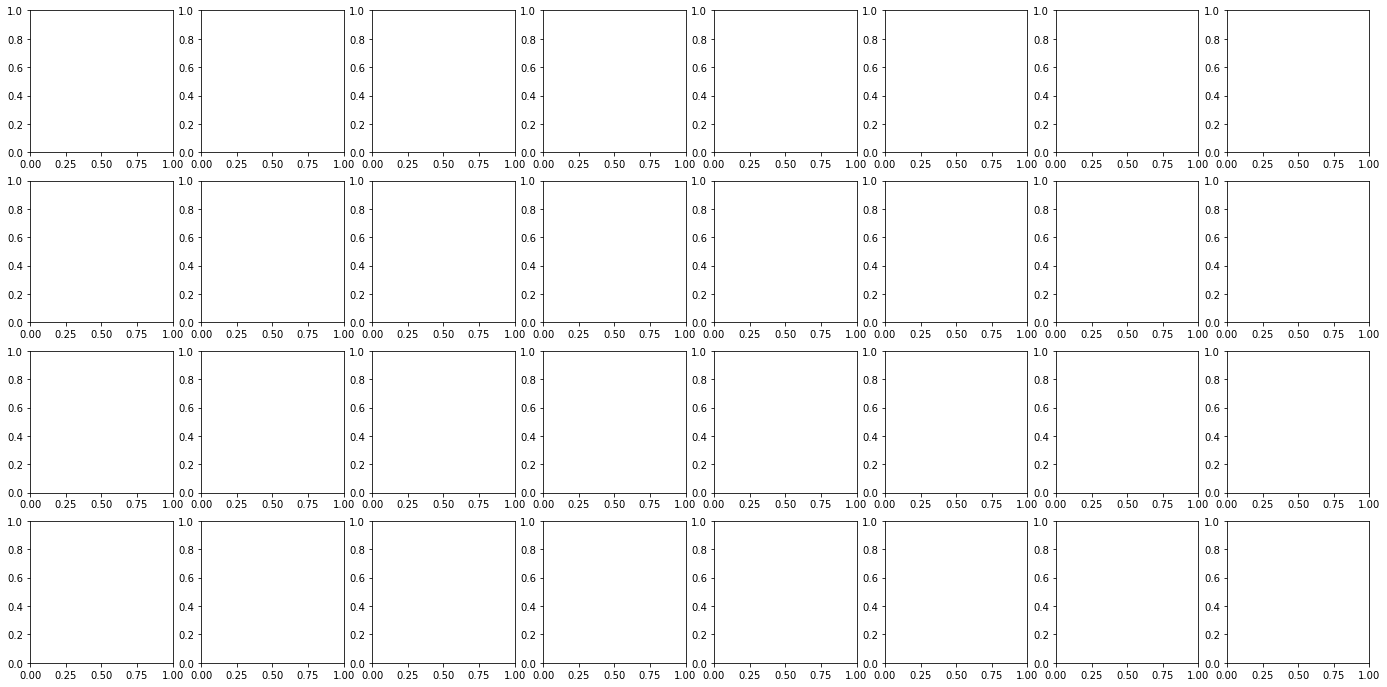

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
# plot filters


f, axs = plt.subplots(4, 8  , figsize=(6*4, 6*2))

axs = plot_memorable(data_csv,idx_least[::-1],axs)
#f.subplots_adjust(hspace=0.6)

#f.savefig('/gpfs01/bethge/home/oeberle/Results/DGII_across_16_least_mem_fig_norm.jpg')


f, axs = plt.subplots(4, 8  , figsize=(6*4, 6*2))

axs = plot_memorable(data_csv,idx_most[::-1],axs)
#f.subplots_adjust(hspace=0.6)
#f.savefig('/gpfs01/bethge/home/oeberle/Results/DGII_across_16_most_mem_fig_norm.jpg')

In [ ]:
# Compute Cross entropy
f, axs = plt.subplots(4, 8  , figsize=(6*4, 6*2))

_, cross_ent_most = plot_memorable(data_csv,idx_most[::-1],axs)


In [ ]:
# Compute Cross entropy
f, axs = plt.subplots(4, 8  , figsize=(6*4, 6*2))

_, cross_ent_least = plot_memorable(data_csv,idx_least[::-1],axs)

In [ ]:
# Compute Cross entropy
f, axs = plt.subplots(4, 8  , figsize=(6*4, 6*2))

_, cross_ent_all = plot_memorable(data_csv,idx_all,axs)

In [ ]:

hr_most = [d['HR'] for k,d in cross_ent_most.iteritems()]
ce_most = [d['cross_entropy'] for k,d in cross_ent_most.iteritems()]

hr_least = [d['HR'] for k,d in cross_ent_least.iteritems()]
ce_lest = [d['cross_entropy'] for k,d in cross_ent_least.iteritems()]

plt.scatter(hr_most + hr_least, ce_most + ce_lest)
plt.show()

In [ ]:
mit1003_stimuli, mit1003_fixations = pysaliency.get_FIGRIM(location='/gpfs01/bethge/home/oeberle/Scripts/deepgaze/')


In [ ]:
mit1003_fixations[mit1003_fixations.n==2].x.shape

In [ ]:
F = np.zeros((1000,1000))

for i,j in zip(list(np.round(mit1003_fixations[mit1003_fixations.n==2].x)), list(np.round(mit1003_fixations[mit1003_fixations.n==2].y))):
    F[int(i),int(j)] += 1.
F = F/np.sum(F)

In [ ]:
print('')

In [20]:

def compute_cross_entropy(log_density, fixations):
    F = np.zeros_like(log_density)
    for i,j in zip(list(np.round(fixations.x)), list(np.round(fixations.y))):
        F[int(i),int(j)] += 1.
    F = F/np.sum(F)
    
    print(fixations)
    
    q = log_density.flatten()
    p = fixations.flatten()
    return -np.dot(q,log_density)

In [16]:
import pysaliency
from scipy.ndimage import gaussian_filter, zoom
def saliency_map(stimulus, fixations, kernel_size):
    stimulus = stimulus
    stimulus_id = stimulus.stimulus_id
    print(stimulus)

    saliency_map = np.zeros(stimulus.size)
    print(fixations.y.astype(int), fixations.x.astype(int))
    saliency_map[fixations.y.astype(int), fixations.x.astype(int)] = 1.0

    if kernel_size:
        saliency_map = gaussian_filter(saliency_map, kernel_size)
    return saliency_map

In [ ]:
n = 18
a = saliency_map(mit1003_stimuli[n], mit1003_fixations[mit1003_fixations.n==n], kernel_size = 35 )
b = a/np.sum(a)
plt.imshow(b)
plt.colorbar()
plt.show()
plt.imshow(mit1003_stimuli.stimuli[n])

In [ ]:
np.sum(b)

In [ ]:
a

In [ ]:
mit1003_stimuli.stimuli[10]